In [1]:
!pip install pycuda

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 28.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 78 kB 8.1 MB/s 
     |████████████████████████████████| 70 kB 8.6 MB/s 
  Created wheel for pycuda: filename=pycuda-2022.1-cp37-cp37m-linux_x86_64.whl size=629484 sha256=d328185e37f8f5075178f338a8d5ed47c40367ed46aff391b2e40ad43310a4a2
  Stored in directory: /root/.cache/pip/wheels/17/53/c9/caa05618e686df51f017d8a9923f38d915ce31df67ab6628e6
  Created wheel for pytools: filename=pytools-2022.1.12-py2.py3-none-any.whl size=65034 sha256=e6fb6d6a0bb2ccfa201b90fafdce1fb322020f171462bda0afd2003968c79c2c
  Stored in directory: /root/.cache/pip/wheels/37/5e/9e/76d7430e116b7cab0016fbabb26b896daae1946a3f7dea9915
Successfully built pycuda pytools


In [2]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
from pycuda import gpuarray

import numpy as np
import math

# Module

In [79]:
class MinimumEnergyControl:
    def __init__(self, x_des, x_0, dt=0.1):

        ## very important constants
        self.axis = 3
        self.DOF  = 6

        ## gravity, criterion: moon
        gravity = 1.62      # N/kg

        ## A
        state_transition_matrix = \
        np.array([[ 1, 0, 0,dt, 0, 0],
                  [ 0, 1, 0, 0,dt, 0],
                  [ 0, 0, 1, 0, 0,dt],
                  [ 0, 0, 0, 1, 0, 0],
                  [ 0, 0, 0, 0, 1, 0],
                  [ 0, 0, 0, 0, 0, 1]])

        ## B
        input_matrix = \
        np.array([[0.5*dt*dt,        0,        0],
                  [        0,0.5*dt*dt,        0],
                  [        0,        0,0.5*dt*dt],
                  [        dt,       0,        0],
                  [        0,        dt,       0],
                  [        0,        0,       dt]])

        self.input_matrix = cuda.mem_alloc(4*2)
        cuda.memcpy_htod(self.input_matrix, input_matrix[::3,0].astype(np.float32))

        ## g
        gravity_matrix = \
        np.array([[                0],
                  [                0],
                  [0.5*gravity*dt*dt],
                  [                0],
                  [                0],
                  [       gravity*dt]])

        self.gravity_matrix = cuda.mem_alloc(4*2)
        cuda.memcpy_htod(self.gravity_matrix, gravity_matrix[2::3].astype(np.float32))

        ## desired state: x_des
        self.x_des = cuda.mem_alloc(4*self.DOF)
        cuda.memcpy_htod(self.x_des, x_des.astype(np.float32))

        ## initial state: x_0
        self.x_0 = cuda.mem_alloc(4*self.DOF)
        cuda.memcpy_htod(self.x_0, x_0.astype(np.float32))

        ## current state: x_current
        self.x_current = cuda.mem_alloc(4*self.DOF)
        cuda.memcpy_htod(self.x_current, x_0.astype(np.float32))
        
        ## dt
        self.dt = np.float32(dt)

        ## weight
        self.rho = 0.1

        ## define kernel function
        self.kernel_function()

    def run(self, step):
        ## get_gradient
        self.get_gradient(self.gram_G,
                          self.u,
                          self.G_C,
                          self.iteration,
                          self.gradient,
                          np.int32(step),
                          block=(self.TPB,1,1),
                          grid=(self.axis*step,1,1))

    def define_problem(self, step):
        ## initialize
        try:
            self.memory_free()
        except:
            pass

        ## TPB, iteration
        self.TPB, self.iteration = self.define_optimal_kernel_size(self.axis*step)

        ## matrices
        self.memory_allocation(step)
        self.define_matrix(step)

    def define_optimal_kernel_size(self, n):
        thread_per_block = int(math.sqrt(n / 2))
        
        iteration = int(n / thread_per_block) + 1

        return thread_per_block, np.int32(iteration)

    def memory_allocation(self, step):
        ## rho matrix: 36 * step * step bytes
        rho_matrix      = (math.sqrt(self.rho) * np.identity(self.axis*step)).astype(np.float32)
        rho_matrix_byte = rho_matrix.nbytes
        self.rho_matrix = cuda.mem_alloc(rho_matrix_byte)
        cuda.memcpy_htod(self.rho_matrix, rho_matrix)

        ## solution!!!
        u      = np.zeros((self.axis*step,1)).astype(np.float32)
        u_byte = u.nbytes
        self.u = cuda.mem_alloc(u_byte)

        ## G
        G       = np.zeros((self.DOF*self.axis*step)).astype(np.float32)
        G_byte = G.nbytes
        self.G = cuda.mem_alloc(G_byte)
        cuda.memcpy_htod(self.G, G)

        ## gram_G
        gram_G      = np.zeros((self.axis*self.axis*step*step)).astype(np.float32)
        gram_G_byte = gram_G.nbytes
        self.gram_G = cuda.mem_alloc(gram_G_byte)
        cuda.memcpy_htod(self.gram_G, gram_G)

        ## Q
        Q      = np.zeros((self.DOF)).astype(np.float32)
        Q_byte = Q.nbytes
        self.Q = cuda.mem_alloc(Q_byte)
        cuda.memcpy_htod(self.Q, Q)

        ## C
        C      = np.zeros((self.DOF)).astype(np.float32)
        C_byte = C.nbytes
        self.C = cuda.mem_alloc(C_byte)
        cuda.memcpy_htod(self.C, C)

        ## G_C
        G_C      = np.zeros((self.axis*step)).astype(np.float32)
        G_C_byte = G_C.nbytes 
        self.G_C = cuda.mem_alloc(G_C_byte)
        cuda.memcpy_htod(self.G_C, G_C)

        ## gradient
        gradient      = np.zeros((self.axis*step)).astype(np.float32)
        gradient_byte = gradient.nbytes
        self.gradient = cuda.mem_alloc(gradient_byte)
        cuda.memcpy_htod(self.gradient, gradient)

    def define_matrix(self, step):
        self.get_G_matrix(self.input_matrix,
                          self.dt,
                          self.G,
                          block=(6,1,1),
                          grid=(step,1,1))
        
        self.get_Q_matrix(self.gravity_matrix,
                          self.dt,
                          self.Q,
                          block=(step,1,1),
                          grid=(2,1,1))
        
        self.get_G_gram_matrix(self.G,
                               self.rho_matrix,
                               self.gram_G,
                               np.int32(step),
                               block=(3,1,1),
                               grid=(step,step,1))
                               
        self.get_G_C_matrix(self.G,
                            self.x_des,
                            self.dt,
                            self.x_0,
                            self.Q,
                            self.C,
                            self.G_C,
                            block=(3,1,1),
                            grid=(step,1,1))

        ## initialize u
        # G = np.empty((self.DOF*self.axis*step)).astype(np.float32)
        # cuda.memcpy_dtoh(G, self.G)
        # G = G.reshape(self.axis*step,self.DOF).T
        
        # rho_matrix = np.empty((self.axis*self.axis*step*step)).astype(np.float32)
        # cuda.memcpy_dtoh(rho_matrix, self.rho_matrix)
        # rho_matrix = rho_matrix.reshape(self.axis*step,self.axis*step)

        # C = np.empty((self.DOF)).astype(np.float32)
        # cuda.memcpy_dtoh(C, self.C)
        # C = C.reshape(self.DOF,1)

        # A = np.vstack((G,rho_matrix))
        # b = np.vstack((C,np.zeros((self.axis*step,1))))

        # opt_u = np.linalg.lstsq(A, b, rcond=None)[0]
        # opt_u = np.round(opt_u, 8).astype(np.float32)
        opt_u = np.zeros((self.axis*step)).astype(np.float32)
        cuda.memcpy_htod(self.u, opt_u)
        

    def memory_free(self):
        self.rho_matrix.free()
        self.u.free()
        self.G.free()
        self.gram_G.free()
        self.Q.free()
        self.C.free()
        self.G_C.free()
        self.gradient.free()

    def memory_freeall(self):

        try:
            self.memory_free()
        except:
            pass

        self.input_matrix.free()
        self.gravity_matrix.free()
        self.x_des.free()
        self.x_0.free()
        self.x_current.free()

    def kernel_function(self):
        ## block=(TPB,1,1), grid=(axis*step,1,1)
        get_gradient_ker_function = \
        """
        #define tx (threadIdx.x)
        #define bx (blockIdx.x)
        #define bs (blockDim.x)
        #define gs (gridDim.x)

        __global__ void get_gradient(float* matrix, float* vector1, float* vector2, int iteration, float* gradient, int step) {

            __shared__ float result[1000];

            result[tx] = 0.0;

            for (int i = 0; i < iteration; i++) {            
                int index1 = i + tx * iteration;
                int index2 = index1 + bx * 3 * step;

                if (index1 < gs) {
                    result[tx] += matrix[index2] * vector1[index1];
                }
                else {
                    result[1000-tx] = 0.0;
                }
            }

            __syncthreads();

            if (tx == 0) {
                gradient[bx] = 0.0;

                for (int j = 0; j < bs; j++) {
                    gradient[bx] += result[j];
                }

                gradient[bx] -= vector2[bx];
            }
            else {
                result[1000-tx] = 0.0;
            }

            __syncthreads();
        }
        """
        get_gradient_ker = SourceModule(get_gradient_ker_function)

        ## block=(6,1,1), grid=(step,1,1)
        get_G_matrix_ker_function = \
        """
        #define tx (threadIdx.x)
        #define bx (blockIdx.x)
        #define step (gridDim.x)

        __global__ void get_G_matrix(float* input_matrix, float dt, float* G) {
            // 6: DOF, 18: axis * DOF
            int index = tx + (tx%3) * 6 + bx * 18;

            if (tx < 3) {
                float value;
                value = input_matrix[0] + (step - bx - 1) * dt * input_matrix[1];

                G[index] = value;
            }
            else {
                G[index] = dt;
            }

            __syncthreads();
        }
        """
        get_G_matrix_ker = SourceModule(get_G_matrix_ker_function)

        ## block=(step,1,1), grid=(2,1,1)
        get_Q_matrix_ker_function = \
        """
        #define tx (threadIdx.x)
        #define bx (blockIdx.x)
        #define step (blockDim.x)

        __global__ void get_Q_matrix(float* gravity, float dt, float* Q) {
            
            __shared__ float value[1000];

            if (bx == 0) {
                value[tx] = gravity[0] + (tx * dt) * gravity[1];
            }
            else {
                value[tx] = gravity[1];
            }

            __syncthreads();

            if (bx == 0) {
                if (tx == 0) {
                    for (int i = 0; i < step; i++) {
                        Q[2] += value[i];
                    }
                }
            }
            else {
                if (tx == 0) {
                    for (int i = 0; i < step; i++) {
                        Q[5] += value[i];
                    }
                }
            }

            __syncthreads();
        }
        """
        get_Q_matrix_ker = SourceModule(get_Q_matrix_ker_function)

        ## block=(3,1,1), grid=(step,step,1)
        get_G_gram_matrix_ker_function = \
        """
        #define tx (threadIdx.x)
        #define bx (blockIdx.x)
        #define by (blockIdx.y)
        #define step (gridDim.x)

        __global__ void get_G_gram_matrix(float* G, float* rho_matrix, float* gram_G) {
            // 3: axis
            int index1 = 3 * step + 1;
            int index2 = 3 * 3 * step;
            int index3 = tx * index1 + bx * 3 + by * index2;

            // 7: DOF+1, 18: axis*DOF
            int index4 = tx * 7 + bx * 18;
            int index5 = tx * 7 + by * 18;

            float value = 0.0;
            value = G[index4] * G[index5] + G[index4+3] * G[index5+3];

            gram_G[index3] = value;

            __syncthreads();

            gram_G[index3] += rho_matrix[index3] * rho_matrix[index3];

            __syncthreads();
        }
        """
        get_G_gram_matrix_ker = SourceModule(get_G_gram_matrix_ker_function)

        ## block=(3,1,1), grid=(step,1,1)
        get_G_C_matrix_ker_function = \
        """
        #define tx (threadIdx.x)
        #define bx (blockIdx.x)
        #define step (gridDim.x)

        __global__ void get_G_C_matrix(float* G, float* x_des, float dt, float* x_current, float* Q, float* C, float * G_C) {

            __shared__ float x_A_powered[6];
            __shared__ float C_jerk[6];

            x_A_powered[tx] = x_current[tx] + step * dt * x_current[tx+3];
            x_A_powered[tx+3] = x_current[tx+3];

            __syncthreads();

            C_jerk[tx] = x_des[tx] - Q[tx] - x_A_powered[tx];
            C_jerk[tx+3] = x_des[tx+3] - Q[tx+3] - x_A_powered[tx+3];

            __syncthreads();

            C[tx] = C_jerk[tx];
            C[tx+3] = C_jerk[tx+3];


            __syncthreads();

            // 7: DOF+1, 18: axis*DOF;
            int index1 = tx * 7 + bx * 18;
            int index2 = tx + bx * 3;

            float value;
            value = G[index1] * C_jerk[tx] + G[index1+3] * C_jerk[tx+3];

            __syncthreads();

            G_C[index2] = value;

            __syncthreads();
        }
        """
        get_G_C_matrix_ker = SourceModule(get_G_C_matrix_ker_function)

        self.get_G_matrix      = get_G_matrix_ker.get_function("get_G_matrix")
        self.get_Q_matrix      = get_Q_matrix_ker.get_function("get_Q_matrix")
        self.get_G_gram_matrix = get_G_gram_matrix_ker.get_function("get_G_gram_matrix")
        self.get_G_C_matrix    = get_G_C_matrix_ker.get_function("get_G_C_matrix")
        self.get_gradient      = get_gradient_ker.get_function("get_gradient")

    def copy_and_unpack_result(self, step):
        ## copy rho matrix
        rho_matrix = np.empty((self.axis*self.axis*step*step)).astype(np.float32)
        cuda.memcpy_dtoh(rho_matrix, self.rho_matrix)

        ## copy solution
        u = np.empty((self.axis*step)).astype(np.float32)
        cuda.memcpy_dtoh(u, self.u)

        ## copy G matrix        
        G = np.empty((self.DOF*self.axis*step)).astype(np.float32)
        cuda.memcpy_dtoh(G, self.G)

        ## copy gram matrix of G
        gram_G = np.empty((self.axis*self.axis*step*step)).astype(np.float32)
        cuda.memcpy_dtoh(gram_G, self.gram_G)

        ## copy Q matrix
        Q = np.empty((self.DOF)).astype(np.float32)
        cuda.memcpy_dtoh(Q, self.Q)

        ## copy C matrix
        C = np.empty((self.DOF)).astype(np.float32)
        cuda.memcpy_dtoh(C, self.C)

        ## copy G_C matrix
        G_C = np.empty((self.axis*step)).astype(np.float32)
        cuda.memcpy_dtoh(G_C, self.G_C)

        ## copy gradient vector
        gradient = np.empty((self.axis*step)).astype(np.float32)
        cuda.memcpy_dtoh(gradient, self.gradient)

        ## pack data
        matrices = dict()
        matrices["rho_matrix"] = rho_matrix.reshape(self.axis*step,self.axis*step)
        matrices["u"]          = u.reshape(self.axis*step,1)
        matrices["G"]          = G.reshape(self.axis*step,self.DOF).T 
        matrices["gram_G"]     = gram_G.reshape(self.axis*step,self.axis*step) 
        matrices["Q"]          = Q.reshape(self.DOF,1)
        matrices["C"]          = C.reshape(self.DOF,1)
        matrices["G_C"]        = G_C.reshape(self.axis*step,1)
        matrices["gradient"]   = gradient.reshape(self.axis*step,1)

        ## delete all memory
        self.memory_freeall()

        return matrices

In [4]:
class OptimizerForGuidance:
    def __init__(self, learning_rate):
        ## set parameters
        self.learning_rate = np.float32(learning_rate)
        
        ## kernel function
        self.kernel_function()

    def run(self, theta, gradient, step):
        ## theta, gradient: gpuarray type variable
        self.basic_optimizer(theta,
                             gradient,
                             self.learning_rate,
                             block=(3,1,1),
                             grid=(step,1,1))

    def kernel_function(self):
        ## block=(3,1,1), grid=(step,1,1)
        basic_optimizer_ker_function = \
        """
        #define tx (threadIdx.x)
        #define bx (blockIdx.x)

        __global__ void basic_optimizer(float* theta, float* gradient, float learning_rate) {
            int index = tx + bx * 3;

            theta[index] -= gradient[index] * learning_rate;

            __syncthreads();
        }
        """
        basic_optimizer_ker = SourceModule(basic_optimizer_ker_function)

        self.basic_optimizer = basic_optimizer_ker.get_function("basic_optimizer")

In [5]:
class ConstraintsForInput:
    def __init__(self, problem, upper_boundary, downer_boundary):
        ## ex> MEC(minimum energy control)
        self.problem = problem

        self.upper_boundary = np.float32(upper_boundary)
        self.downer_boundary = np.float32(downer_boundary)

        ## kernel function
        self.kernel_function()

    def projection(self, step):
        self.project_function(self.problem.u,
                              self.upper_boundary,
                              self.downer_boundary,
                              block=(3,1,1),
                              grid=(step,1,1))

    def kernel_function(self):
        ##block=(3,1,1), grid=(step,1,1)
        projection_ker_function = \
        """
        #define tx (threadIdx.x)
        #define bx (blockIdx.x)

        __device__ float square_root(float value) {
            float s = 0;
            float t = 0;

            s = value / 2;

            for (;s != t;) {
                t = s;
                s = ((value/t) + t) / 2;
            }

            return s;
        }

        __device__ float get_norm(float* vector, int length) {
            float value = 0.0;
            float norm;

            for (int i = 0; i < length; i++) {
                value += vector[i] * vector[i];
            }

            norm = square_root(value);

            return norm;
        }

        __global__ void projection(float* theta, float upper_boundary, float downer_boundary) {

            __shared__ float u[3];
            __shared__ float norm[1];
            __shared__ float value[3];

            int index = tx + bx * 3;

            u[tx] = theta[index];

            __syncthreads();

            if (tx == 0) {
                norm[0] = get_norm(u, 3);
            }

            __syncthreads();

            if ((norm[0] > downer_boundary) && (norm[0] < upper_boundary)) {
                value[tx] = u[tx];
            }
            else {
                value[tx] = u[tx] * upper_boundary / norm[0];
            }

            __syncthreads();

            theta[index] = value[tx];
        }
        """
        projection_ker = SourceModule(projection_ker_function)

        self.project_function = projection_ker.get_function("projection")

# Solver 

In [17]:
class MinimumEnergyControlSolver:
    def __init__(self, x_des, x_0, upper_boundary, downer_boundary, step=50, max_iteration=200):
        ## important constants
        self.axis = 3
        self.DOF  = 6
        self.initial_step = step

        ## step size
        self.step = step
        
        ## max iteration
        self.max_iteration = max_iteration

        ## initialize MEC(minimum energy control)
        self.MEC = MinimumEnergyControl(x_des, x_0)

        ## initialize optimizer
        learning_rate = 1e-4

        self.optimizer = OptimizerForGuidance(learning_rate)

        ## constraint
        self.upper_boundary  = upper_boundary
        self.downer_boundary = downer_boundary

        self.constraint = ConstraintsForInput(self.MEC, self.upper_boundary, self.downer_boundary)

        ## compare error for learning rate tuning
        # self.error_compare = gpuarray.to_gpu(np.array([1e8,0]).astype(np.float32))

        ## initial kernel size
        self.TPB = int(math.sqrt(step))
        self.iteration = int(math.sqrt(step))

    def solve(self):
        ## define problem: fit matrices for left step
        self.define_problem()

        ## iteration
        iteration = 0

        while (iteration < self.max_iteration):
            ## get gradient
            self.MEC.run(self.step)

            ## optimize
            self.optimizer.run(self.MEC.u, self.MEC.gradient, self.step)

            ## constraint
            self.constraint.projection(self.step)
    
            ## evaluate
            self.calculate_error(iteration)
            # self.evaluate(iteration)
            # self.optimizer.learning_rate *= 1.2

            ## update...
            iteration += 1

        ## update state
        # self.update_state(step)

        ## record data

        ## get next step


    def define_problem(self):
        ## define_problem
        self.MEC.define_problem(self.step)

        ## evaluate
        ## error_vector
        error_vector      = np.zeros((self.DOF + self.axis*self.step)).astype(np.float32)
        error_vector_byte = error_vector.nbytes
        self.error_vector = cuda.mem_alloc(error_vector_byte)
        cuda.memcpy_htod(self.error_vector, error_vector)

        ## error for record
        error      = np.zeros((self.max_iteration)).astype(np.float32)
        error_byte = error.nbytes
        self.error = cuda.mem_alloc(error_byte)
        cuda.memcpy_htod(self.error, error)

        ## for compare


        ## state record
        # state      = np.zeros((self.DOF*self.step)).astype(np.float32)
        # state_byte = state.nbytes
        # self.state = cuda.mem_alloc(state_byte)
        # cuda.memcpy_htod(self.state, state)

        ## control input
        # input      = np.zeros((self.axis*self.step)).astype(np.float32)
        # input_byte = input.nbytes
        # self.input = cuda.mem_alloc(input_byte)
        # cuda.memcpy_htod(self.input, input)

        ## norm of gradient
        # norm_of_gradient      = np.zeros((1)).astype(np.float32)
        # norm_of_gradient_byte = norm_of_gradient.nbytes
        # self.norm_of_gradient = cuda.mem_alloc(norm_of_gradient_byte)
        # cuda.memcpy_htod(self.norm_of_gradient, norm_of_gradient)

        ## kernel function
        self.kernel_function()

        ## kernel size
        self.TPB, self.iteration = self.define_optimal_kernel_size(self.axis * self.step)
    
    def define_optimal_kernel_size(self, n):
        thread_per_block = int(math.sqrt(n / 2))
        
        iteration = int(n / thread_per_block) + 1

        return thread_per_block, np.int32(iteration)

    def evaluate(self, iteration):
        ## get error
        self.calculate_error(iteration)

        ## learning_rate tuning
        if (self.error_compare[0].get() > self.error_compare[1].get()): 
            ## good way
            self.optimizer.learning_rate *= 1.2

            # ## differential
            # self.get_norm(self.MEC.gradient,
            #               self.norm_of_gradient,
            #               np.int32(self.iteration),
            #               block=(self.TPB,1,1),
            #               grid=(1,1,1))

            # if self.norm_of_gradient < self.epsilon:
            #     ## learning over
            #     return True
            # else:
            #     ## keep learn
            #     pass
        else:
            ## bad way
            self.optimizer.learning_rate *= 0.5

        ## ready for next iteration
        self.error_compare[0] = self.error_compare[1]

    def calculate_error(self, iteration):

        ## set size
        block_size = self.step + 2
        grid_size  = self.axis * self.step + self.DOF

        ## evaluate learning
        self.get_error_vector(self.MEC.G,
                              self.MEC.rho_matrix,
                              self.MEC.u,
                              self.MEC.C,
                              self.iteration,
                              self.error_vector,
                              block=(self.TPB,1,1),
                              grid=(grid_size,1,1))
        
        self.get_error(self.error_vector,
                       self.error,
                       np.int32(iteration),
                       block=(block_size,1,1),
                       grid=(1,1,1))

    def update_state(self, step):
        ## update state
        self.get_next_state(self.MEC.x_current,
                            self.MEC.u,
                            self.MEC.dt,
                            self.MEC.gravity_matrix,
                            self.state,
                            np.int32(step),
                            block=(6,1,1),
                            grid=(1,1,1))

    def memory_free(self):
        pass

    def memory_freeall(self):

        try:
            self.MEC.memory_freeall()

        except:
            pass

        self.error_vector.free()
        self.error.free()
        # self.state.free()

    def kernel_function(self):
        ## block=(TPB,1,1), grid=(DOF+axis*step,1,1)
        get_error_vector_ker_function = \
        """
        #define tx (threadIdx.x)
        #define bx (blockIdx.x)
        #define bs (blockDim.x)
        #define gs (gridDim.x)

        __global__ void get_error_vector(float* G, float* rho_matrix, float* u, float* C, int iteration, float* error_vector) {
            
            if (bx < 6) {
                __shared__ float value[1000];

                value[tx] = 0.0;

                __syncthreads();

                for (int i = 0; i <iteration; i++) {
                    int index1 = i + tx * iteration;
                    int index2 = index1 * 6 + bx;

                    value[tx] += G[index2] * u[index1];
                }

                __syncthreads();

                if (tx == 0) {
                    value[1000] = 0.0;

                    for (int j = 0; j < bs; j++) {
                        value[1000] += value[j];
                    }

                    error_vector[bx] = value[50] - C[bx];
                }
            }
            else {
                if (tx == 0) {
                    int index1 = bx - 6;
                    int index2 = gs - 5;
                    int index3 = index1 * index2;

                    error_vector[bx] = rho_matrix[index3] * u[index1];
                }

                __syncthreads();
            }
        }
        """
        get_error_vector_ker = SourceModule(get_error_vector_ker_function)

        ## block=(step+2,1,1), grid=(1,1,1)
        get_error_ker_function = \
        """
        #define tx (threadIdx.x)
        #define bx (blockIdx.x)
        #define bs (blockDim.x)

        __device__ float square_root(float value) {
            float s = 0;
            float t = 0;

            s = value / 2;

            for (;s != t;) {
                t = s;
                s = ((value/t) + t) / 2;
            }

            return s;
        }

        __device__ float get_norm(float* vector, int length) {
            float value = 0.0;
            float norm;

            for (int i = 0; i < length; i++) {
                value += vector[i] * vector[i];
            }

            norm = square_root(value);

            return norm;
        }

        __global__ void get_error(float* error_vector, float* error, int current_step) {

            __shared__ float value[1000];

            int index = tx * 3;

            for (int i = 0; i < 3; i++) {
                value[index+i] = error_vector[index+i];
            }

            __syncthreads();

            if (tx == 0) {
                int length = bs;

                error[current_step] = get_norm(value, length);
            }

            __syncthreads();
        }
        """
        get_error_ker = SourceModule(get_error_ker_function)

        ## block=(6,1,1), grid=(1,1,1)
        get_next_state_ker_function = \
        """
        #define tx (threadIdx.x)

        __global__ void get_next_state(float* x, float* u, float dt, float* gravity_matrix, float* state, int step) {

            __shared__ float momentum[6];
            __shared__ float control[6];
            __shared__ float gravity[6];

            int index1 = tx + step * 6;
            // int index2 = tx + step * 3;
            int index3 = tx % 3;

            if (tx < 3) {

                momentum[tx] = x[tx] + dt * x[tx+3];
                control[tx]  = 0.5*dt*dt * u[index3];

                if (index3 == 2) {
                    gravity[tx] = gravity_matrix[tx];
                }
                else {
                    gravity[tx] = 0.0;
                }

                // input[index2] = u[index3]; 
            }
            else {

                momentum[tx] = x[tx];
                control[tx]  = dt * u[index3];

                if (index3 == 2) {
                    gravity[tx] = gravity_matrix[tx];
                }
                else {
                    gravity[tx] = 0.0;
                }
            }

            __syncthreads();

            x[tx] = momentum[tx] + control[tx] + gravity[tx];
            state[index1] = x[tx];

            __syncthreads();
        }
        """
        get_next_state_ker = SourceModule(get_next_state_ker_function)

        self.get_error_vector = get_error_vector_ker.get_function("get_error_vector")
        self.get_error        = get_error_ker.get_function("get_error")
        self.get_next_state   = get_next_state_ker.get_function("get_next_state")

    def copy_and_unpack_result(self):
        
        ## unpack matrix
        try:
            matrices = self.MEC.copy_and_unpack_result(self.step)
        except:
            matrices = dict()

        ## copy error
        error = np.empty((self.max_iteration)).astype(np.float32)
        cuda.memcpy_dtoh(error, self.error)

        ## copy error_vector
        error_vector = np.empty((self.axis * self.step)).astype(np.float32)
        cuda.memcpy_dtoh(error_vector, self.error_vector)

        ## copy state
        # state = np.empty((self.DOF*self.initial_step)).astype(np.float32)
        # cuda.memcpy_dtoh(state, self.state)

        ## copy input
        # input= np.empty((self.axis*self.initial_step)).astype(np.float32)
        # cuda.memcpy_dtoh(input, self.input)

        ## pack data
        matrices["error"] = error.reshape(self.max_iteration)
        matrices["error_vector"] = error_vector.reshape(self.axis*self.step,1)
        # matrices["state"] = state.reshape(self.initial_step,self.DOF).T
        # matrices["input"] = input.reshape(self.initial_step,self.axis).T

        ## delete all memory
        self.memory_freeall()

        return matrices

# Test

In [13]:
import matplotlib.pyplot as plt

In [53]:
x_des = np.array([0,0,0,0,0,0])

x_0 = np.array([100,0,-1500,-10,0,80])

MEC = MinimumEnergyControl(x_des, x_0)

optimizer = OptimizerForGuidance(1e-4)

step = 300

In [54]:
MEC.define_problem(step)

In [55]:
result = MEC.copy_and_unpack_result(step)

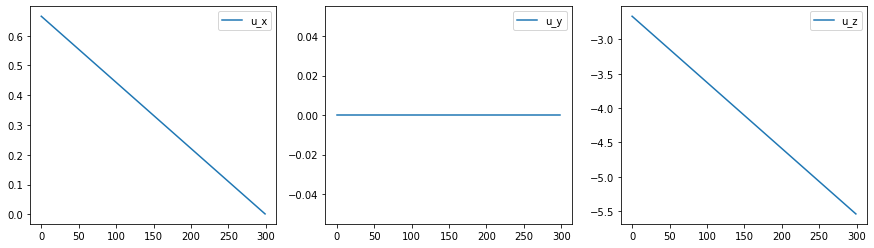

In [12]:
plt.figure(figsize=(15,4))

plt.subplot(131)
plt.plot(result["u"][0::3], label="u_x")
plt.legend()

plt.subplot(132)
plt.plot(result["u"][1::3], label="u_y")
plt.legend()

plt.subplot(133)
plt.plot(result["u"][2::3], label="u_z")
plt.legend()

plt.show()

In [ ]:
for i in range(5000):
    MEC.run(step)
    optimizer.run(MEC.u, MEC.gradient, step)

In [ ]:
result = MEC.copy_and_unpack_result(step)

In [ ]:
result["C"]

array([[  200.     ],
       [    0.     ],
       [-1629.     ],
       [   10.     ],
       [    0.     ],
       [ -128.59993]], dtype=float32)

In [16]:
result["G"][:,:3]

array([[2.9950001, 0.       , 0.       ],
       [0.       , 2.9950001, 0.       ],
       [0.       , 0.       , 2.9950001],
       [0.1      , 0.       , 0.       ],
       [0.       , 0.1      , 0.       ],
       [0.       , 0.       , 0.1      ]], dtype=float32)

In [ ]:
result["gradient"][2:36:3]

array([[-1.5322266],
       [-1.5175781],
       [-1.5029297],
       [-1.4863281],
       [-1.4711914],
       [-1.4570312],
       [-1.440918 ],
       [-1.4248047],
       [-1.409668 ],
       [-1.3935547],
       [-1.378418 ],
       [-1.3647461]], dtype=float32)

In [ ]:
A = np.vstack(((result["G"]), result["rho_matrix"]))
b = np.vstack(((result["C"]), np.zeros((3*step,1))))

In [ ]:
np.linalg.norm(np.dot(A, result["u"]) - b)

23.681783415818206

In [ ]:
A.shape

(906, 900)

In [ ]:
b.shape

(906, 1)

In [ ]:
(result["gram_G"] @ result["u"] - result["G_C"])[:12]

array([[ 0.0000000e+00],
       [ 0.0000000e+00],
       [-4.8828125e-04],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 4.8828125e-04],
       [ 6.1035156e-05],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00]], dtype=float32)

## Initialize u

In [ ]:
opt_u = np.linalg.lstsq(A, b, rcond=None)[0]

In [ ]:
np.round(opt_u, 8)[2:36:3]

array([[-2.66187942],
       [-2.67151086],
       [-2.6811423 ],
       [-2.69077374],
       [-2.70040518],
       [-2.71003684],
       [-2.71966805],
       [-2.72929949],
       [-2.73893093],
       [-2.7485626 ],
       [-2.75819404],
       [-2.76782525]])

In [ ]:
np.linalg.norm(np.dot(A, opt_u) - b)

23.681785009064996

In [ ]:
result["Q"]

array([[  0.      ],
       [  0.      ],
       [729.      ],
       [  0.      ],
       [  0.      ],
       [ 48.599926]], dtype=float32)

In [ ]:
result["G_C"][:12]

array([[  600.    ],
       [    0.    ],
       [-4891.7153],
       [  598.    ],
       [    0.    ],
       [-4875.4253],
       [  596.    ],
       [    0.    ],
       [-4859.1353],
       [  594.    ],
       [    0.    ],
       [-4842.845 ]], dtype=float32)

In [ ]:
result["C"]

array([[  200.     ],
       [    0.     ],
       [-1629.     ],
       [   10.     ],
       [    0.     ],
       [ -128.59993]], dtype=float32)

# Test MECS

In [ ]:
import matplotlib.pyplot as plt

In [98]:
x_des = np.array([0,0,0,0,0,0])

x_0 = np.array([100,0,-1500,-10,0,80])

upper_boundary = 5.0
downer_boundary = 0.0

MECS = MinimumEnergyControlSolver(x_des, x_0, upper_boundary, downer_boundary, step=300, max_iteration=5000)

In [99]:
MECS.solve()

In [100]:
result = MECS.copy_and_unpack_result()

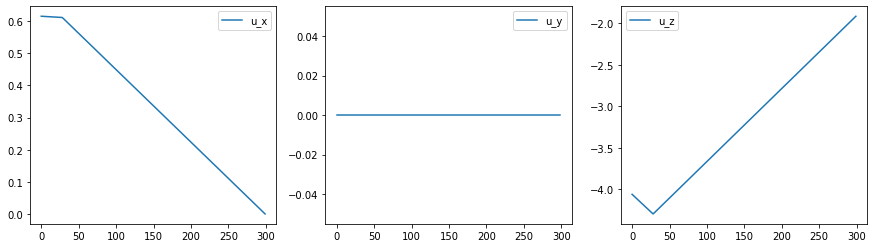

In [101]:
plt.figure(figsize=(15,4))

plt.subplot(131)
plt.plot(result["u"][0::3], label="u_x")
plt.legend()

plt.subplot(132)
plt.plot(result["u"][1::3], label="u_y")
plt.legend()

plt.subplot(133)
plt.plot(result["u"][2::3], label="u_z")
plt.legend()

plt.show()

In [102]:
dt = 0.1
gravity = 1.62
A = \
np.array([[ 1, 0, 0,dt, 0, 0],
            [ 0, 1, 0, 0,dt, 0],
            [ 0, 0, 1, 0, 0,dt],
            [ 0, 0, 0, 1, 0, 0],
            [ 0, 0, 0, 0, 1, 0],
            [ 0, 0, 0, 0, 0, 1]])

## B
B = \
np.array([[0.5*dt*dt,        0,        0],
            [        0,0.5*dt*dt,        0],
            [        0,        0,0.5*dt*dt],
            [        dt,       0,        0],
            [        0,        dt,       0],
            [        0,        0,       dt]])

## g
g = \
np.array([[                0],
            [                0],
            [0.5*gravity*dt*dt],
            [                0],
            [                0],
            [       gravity*dt]])

state = np.zeros((6,300))
state[:,0] = np.array([100,0,-1500,-10,0,80])

for i in range(299):
    state[:,i+1] = np.dot(A, state[:,i]) + np.dot(B, result["u"][3*i:3*i+3]).T + g.T

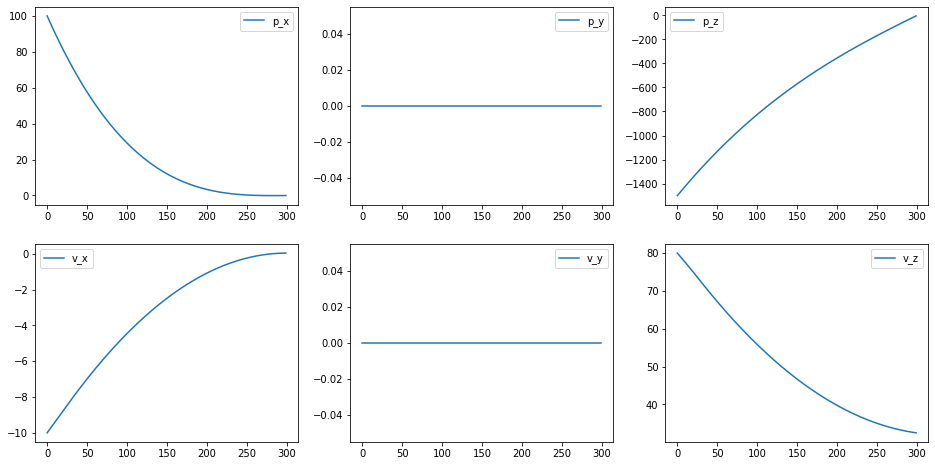

In [103]:
plt.figure(figsize=(16,8))


plt.subplot(231)
plt.plot(state[0,:], label="p_x")
plt.legend()

plt.subplot(232)
plt.plot(state[1,:], label="p_y")
plt.legend()

plt.subplot(233)
plt.plot(state[2,:], label="p_z")
plt.legend()

plt.subplot(234)
plt.plot(state[3,:], label="v_x")
plt.legend()

plt.subplot(235)
plt.plot(state[4,:], label="v_y")
plt.legend()

plt.subplot(236)
plt.plot(state[5,:], label="v_z")
plt.legend()

plt.show()

In [104]:
state[:,-1]

array([-2.69723650e-02,  0.00000000e+00, -4.68683474e+00,  3.16398721e-02,
        0.00000000e+00,  3.24647528e+01])

In [105]:
u_norm = np.zeros((300,1))

for i in range(300):
    u_norm[i,0] = np.linalg.norm(result["u"][3*i:3*i+3])

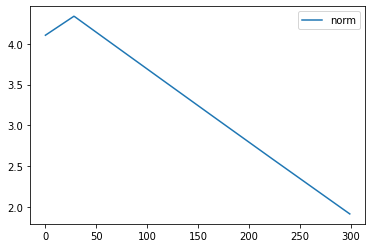

In [106]:
plt.plot(u_norm[:], label="norm")
plt.legend()

plt.show()

In [67]:
(result["gram_G"] - np.dot(result["rho_matrix"], result["rho_matrix"]))[:12]

array([[8.980025, 0.      , 0.      , ..., 0.024975, 0.      , 0.      ],
       [0.      , 8.980025, 0.      , ..., 0.      , 0.024975, 0.      ],
       [0.      , 0.      , 8.980025, ..., 0.      , 0.      , 0.024975],
       ...,
       [8.890176, 0.      , 0.      , ..., 0.024825, 0.      , 0.      ],
       [0.      , 8.890176, 0.      , ..., 0.      , 0.024825, 0.      ],
       [0.      , 0.      , 8.890176, ..., 0.      , 0.      , 0.024825]],
      dtype=float32)

In [ ]:
x_0.reshape(6,1) + np.dot(result["G"], result["u"]) + result["Q"]

array([[ 2.99977783e+02],
       [ 0.00000000e+00],
       [-2.40009644e+03],
       [-1.26838684e-04],
       [ 0.00000000e+00],
       [ 5.54649734e+00]])

In [ ]:
A = np.vstack((result["G"], result["rho_matrix"]))
b = np.vstack((result["C"], np.zeros((3*300,1))))

np.linalg.norm(np.dot(A, result["u"]) - b)

23.681783415818206

In [26]:
result["error"]

array([1646.383 , 1646.5898], dtype=float32)

In [ ]:
np.linalg.norm(result["error_vector"])

1646.7194